In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#%matplotlib notebook
import colorsys
import numpy as np
import pandas as pd
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
from nettools.monoplex import NetworkGenerator 
from nettools.multiplex import MultiplexConstructor
from nettools.multiplex import InterMeasures
from nettools.monoplex import CentralityMeasure
from nettools.epidemic import SISMultiplex, SIRMultiplex
from nettools.utils import load_multinet_by_name, NX_CENTRALITY
from nettools.utils.ctest import spread_eff_centr_test

# Centrality for multiplex synthetic networks
In this notebook I describe centrality measure for *monoplex* and *multiplex* synthetic networks, besides that I will spread disease on each tested network, using seed nodes with greatest centrality score, results will be noted and ploted. My aim is to find best seed node for multiplex networks.

### Reasearch approach
In my reaserch I will test centrality on:
* Aggregated networks
* Weighted Aggregated networks
* Mulitplex Measures

### Synthetic networks used in reaserch
In my work I will use five synthetic networks: 
* **ER-ER** Network
* **ER-BA** Network
* **BA-BB** Network
* **BA-BA** Not correlated Network
* **BA-BA** Correlated Network

# Reaserch enviroment
<img src="../images/settings_logo.jpg", width=400, height=400></img>

In [3]:
avg_deg = 6.0
network_size = 300
ng = NetworkGenerator(network_size)
network_ba_1 = ng.ba_network(m0=int(avg_deg / 2))
network_ba_2 = ng.ba_network(m0=int(avg_deg / 2))
network_er_1 = ng.er_network(p=(avg_deg / float(network_size)))
network_er_2 = ng.er_network(p=(avg_deg / float(network_size)))
network_bb_1 = ng.bb_network(m0=int(avg_deg / 2))

Define network constructor and create correlated network for **BA** Network.

In [4]:
mc = MultiplexConstructor()
network_corr_ba_1 = mc.rewire_hubs(network_ba_1, rsteps=5000)

Create multiplex networks.

In [5]:
multi_erer = mc.construct(network_er_1, network_er_2)
multi_erba = mc.construct(network_er_2, network_ba_1)
multi_babb = mc.construct(network_ba_1, network_bb_1)
multi_baba_nc = mc.construct(network_ba_2, network_ba_1)
multi_baba_corr = mc.construct(network_ba_1, network_corr_ba_1)

After preparing 5 networks for test, create 2 single layer networks for veryfication

In [6]:
network_ba_single = ng.ba_network(m0=int(avg_deg / 2))
network_er_single = ng.er_network(p=(avg_deg / float(network_size)))

# Multiplex Networks
<img src="../images/multi.png", width=400, height=400></img>

## 1. Centrality for aggregated network
In second step network centrality will be examined using aggregated networks. 

In [7]:
agg_net_erer = InterMeasures.aggregate(multi_erer.network)
agg_net_erba = InterMeasures.aggregate(multi_erba.network)
agg_net_babb = InterMeasures.aggregate(multi_babb.network)
agg_net_baba_nc = InterMeasures.aggregate(multi_baba_nc.network)
agg_net_baba_corr = InterMeasures.aggregate(multi_baba_corr.network)

## 1.1 Experiment:
During test I found that centrality score and spreading efficiency correlation hardly depends on epidemic rate used on each layer. In first experiment I will use same epidemic rate, in second step I will use different epidemic rates.

### 1.1.1 ER-ER Network
I will examine spreading on mutilayer network, where centrality nodes were calculated using aggregated network.
For spreading different spreading coefficients will be used for each network.
For this network I will use: <br>
$$ \beta_A = 0.1 $$ <br> $$ \beta_{AB} = 0.1 $$ <br> $$ \beta_B = 0.1 $$ <br> $$\beta_{AB} = 0.1$$

First centrality score for each node is computed, in next step this score will be used to begin epidemy.

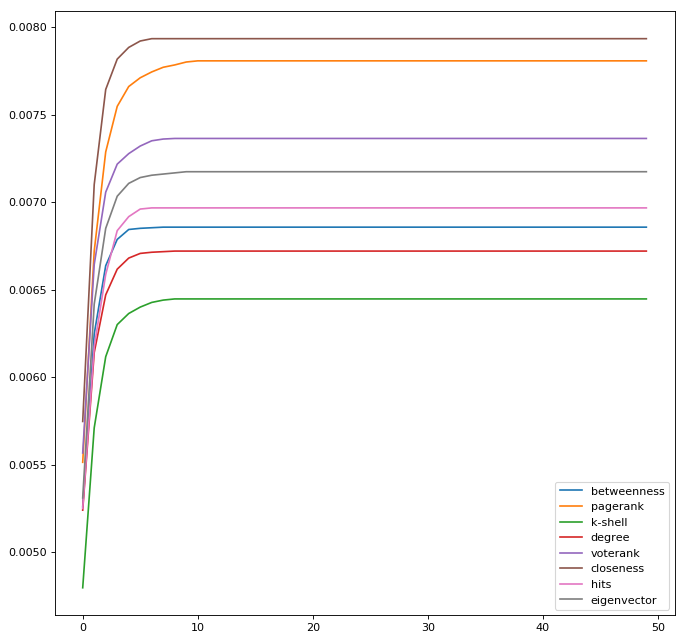

In [8]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for idx, method in enumerate(NX_CENTRALITY.keys()):
    if method == "supernode":
        continue
    avg_results = np.zeros((500, 50))
    for n_time in range(0, 500):
        cn = CentralityMeasure(agg_net_erer)
        results_cn = cn.network_cn(method)
        if method == 'hits':
            results_cn = results_cn[1]
        best_nodes = sorted(results_cn.items(), key=lambda x: x[1])[::-1]
        beta_param = {0: {0: 0.1, 1: 0.1}, 1: {0: 0.1, 1: 0.1}}
        rec_param = {0: {0: 1.0, 1: 1.0}, 1: {0: 1.0, 1: 1.0}}
        sir = SIRMultiplex(multi_erer, beta=beta_param, mu=rec_param, seed_nodes=[best_nodes[0][0]])
        result_sir = sir.run(epochs=50)
        avg_results[n_time] = np.array(result_sir)
    plt.plot(np.mean(avg_results, axis=0) / float(network_size * multi_erer.network.shape[2]), 
             hold=True, label=method)
plt.legend()
plt.show(True)

In [9]:
cent_dict_erer = {}
cent_val_erer = {}
cent_dict_erer_15 = {}
cm_erer = CentralityMeasure(agg_net_erer)
for method in NX_CENTRALITY.keys():
    if method == 'supernode':
        continue
    results = cm_erer.network_cn(method)
    if method == 'hits':
        results = results[1]
    best_nodes = sorted(results.items(), key=lambda x: x[1])[::-1]
    cent_val_erer[method] = sorted(results.values())[::-1]
    cent_dict_erer[method] = [cnt[0] for cnt in best_nodes]
    cent_dict_erer_15[method] = [cnt[0] for cnt in best_nodes[:15]]

In [10]:
scores = {}
scores_15 = {}
mean_realisation = 500
for method, nodes in cent_dict_erer.items():
    node_labels = []
    nodes_scores = []
    for node in nodes:
        mean_spread = []
        for _ in range(mean_realisation):
            beta_param = {0: {0: 0.1, 1: 0.1}, 1: {0: 0.1, 1: 0.1}}
            rec_param = {0: {0: 1.0, 1: 1.0}, 1: {0: 1.0, 1: 1.0}}
            sis = SIRMultiplex(multi_erer, beta=beta_param, mu=rec_param, seed_nodes=[node])
            sis.run(epochs=10, visualize=False)
            mean_spread.append(sis.get_num('i') + sis.get_num('r'))
        node_labels.append(node)
        nodes_scores.append(np.mean(mean_spread))
    scores[method] = node_labels, nodes_scores
    scores_15[method] = nodes_scores[:15]
pd.DataFrame.from_dict(scores_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,3.966,5.082,4.308,4.532,4.236,3.848,4.610,4.338
1,3.438,4.172,4.366,4.190,4.150,3.940,3.976,4.030
2,4.372,4.850,3.346,5.428,5.554,2.970,3.360,5.040
3,4.712,4.274,4.400,4.792,4.872,3.974,4.874,5.516
4,5.182,3.270,4.776,4.458,4.148,4.510,5.540,3.394
5,4.270,4.914,5.500,3.394,3.346,4.468,4.136,4.434
6,3.532,3.744,3.640,4.928,4.906,5.026,4.282,3.582
7,5.696,3.462,4.736,3.884,3.998,3.318,3.762,4.820
8,4.214,4.360,5.026,4.898,4.880,3.432,4.970,5.006
9,5.136,5.650,4.352,3.828,3.788,4.228,5.446,4.628


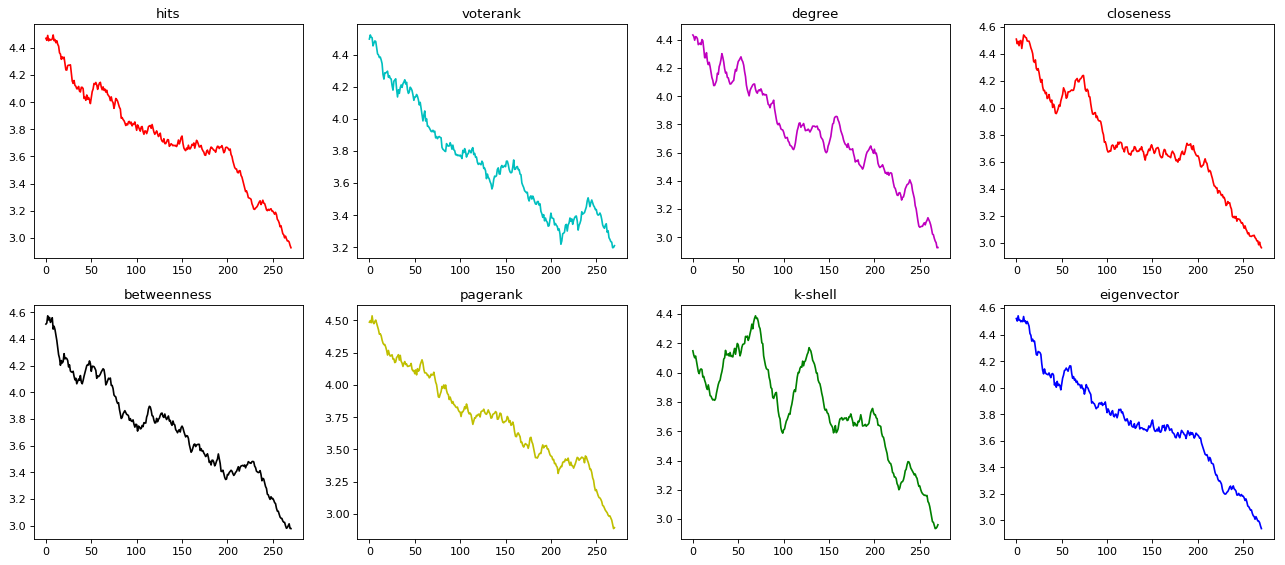

In [11]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
colors = "bgrcmrkygbb"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    sp = plt.subplot(840 + idx_counter)
    sp.plot(running_mean(nd_lab_scores[1], 30), colors[idx_counter + 1])
    sp.set_title(method)
    idx_counter += 1
plt.show()

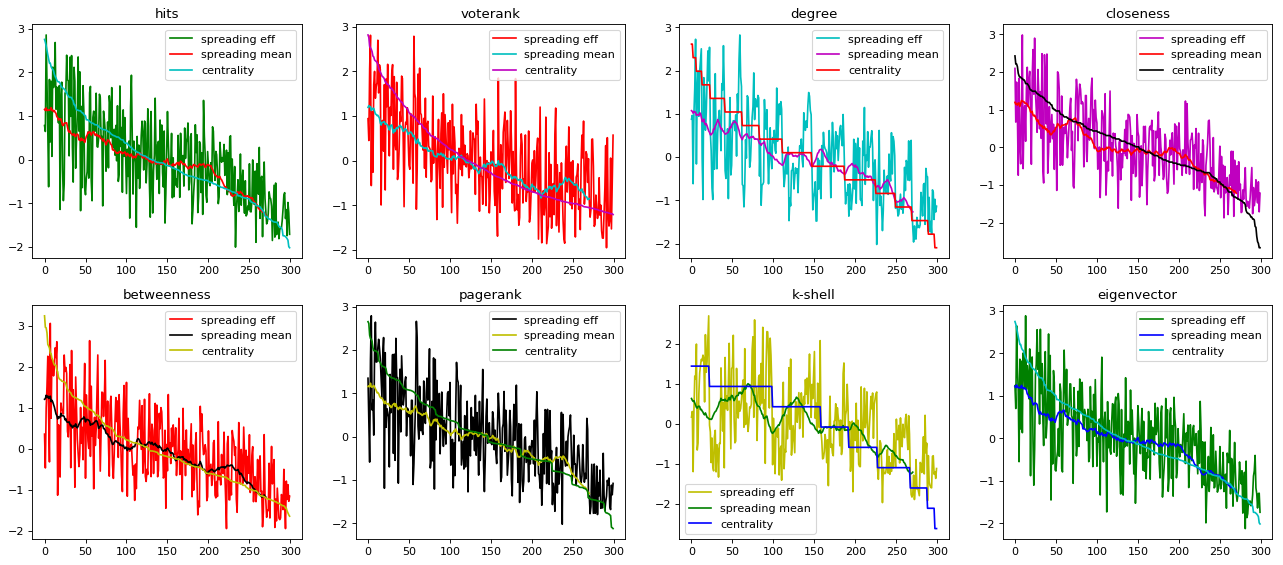

Kendal Correlation


,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,0.467482,0.46897,0.498316,0.485787,0.471062,0.460648,0.481486,0.403893


In [12]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
corr_kendal = {}
colors = "bgrcmrkygbcmgrc"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    normalized_spread = (np.array(nd_lab_scores[1]) - np.mean(nd_lab_scores[1])) / np.std(nd_lab_scores[1])
    normalized_cent = (cent_val_erer[method] - np.mean(cent_val_erer[method])) / np.std(cent_val_erer[method])
    sp = plt.subplot(840 + idx_counter)
    sp.plot(normalized_spread, colors[idx_counter], label="spreading eff")
    sp.plot(running_mean(normalized_spread, 30), colors[idx_counter + 1], label="spreading mean")
    sp.plot(normalized_cent, colors[idx_counter + 2], label="centrality")
    sp.legend()
    tau, p_value = stats.kendalltau(
                    nd_lab_scores[1],
                    cent_val_erer[method]
                )
    corr_kendal[method] = [tau]
    sp.set_title(method)
    idx_counter += 1
plt.show()
print("Kendal Correlation")
pd.DataFrame.from_dict(corr_kendal)

In [13]:
%%capture
print("Network generated and constructed!")
beta_param = {0: {0: 0.1, 1: 0.1}, 1: {0: 0.1, 1: 0.1}}
rec_param = {0: {0: 1.0, 1: 1.0}, 1: {0: 1.0, 1: 1.0}}
test_props = {'mean_num': 1500, "epochs": 35, "beta": beta_param, "mu": rec_param}
print("Start process...")
spread_val, cent_scores, results_names = spread_eff_centr_test(multi_erer, test_properties=test_props)

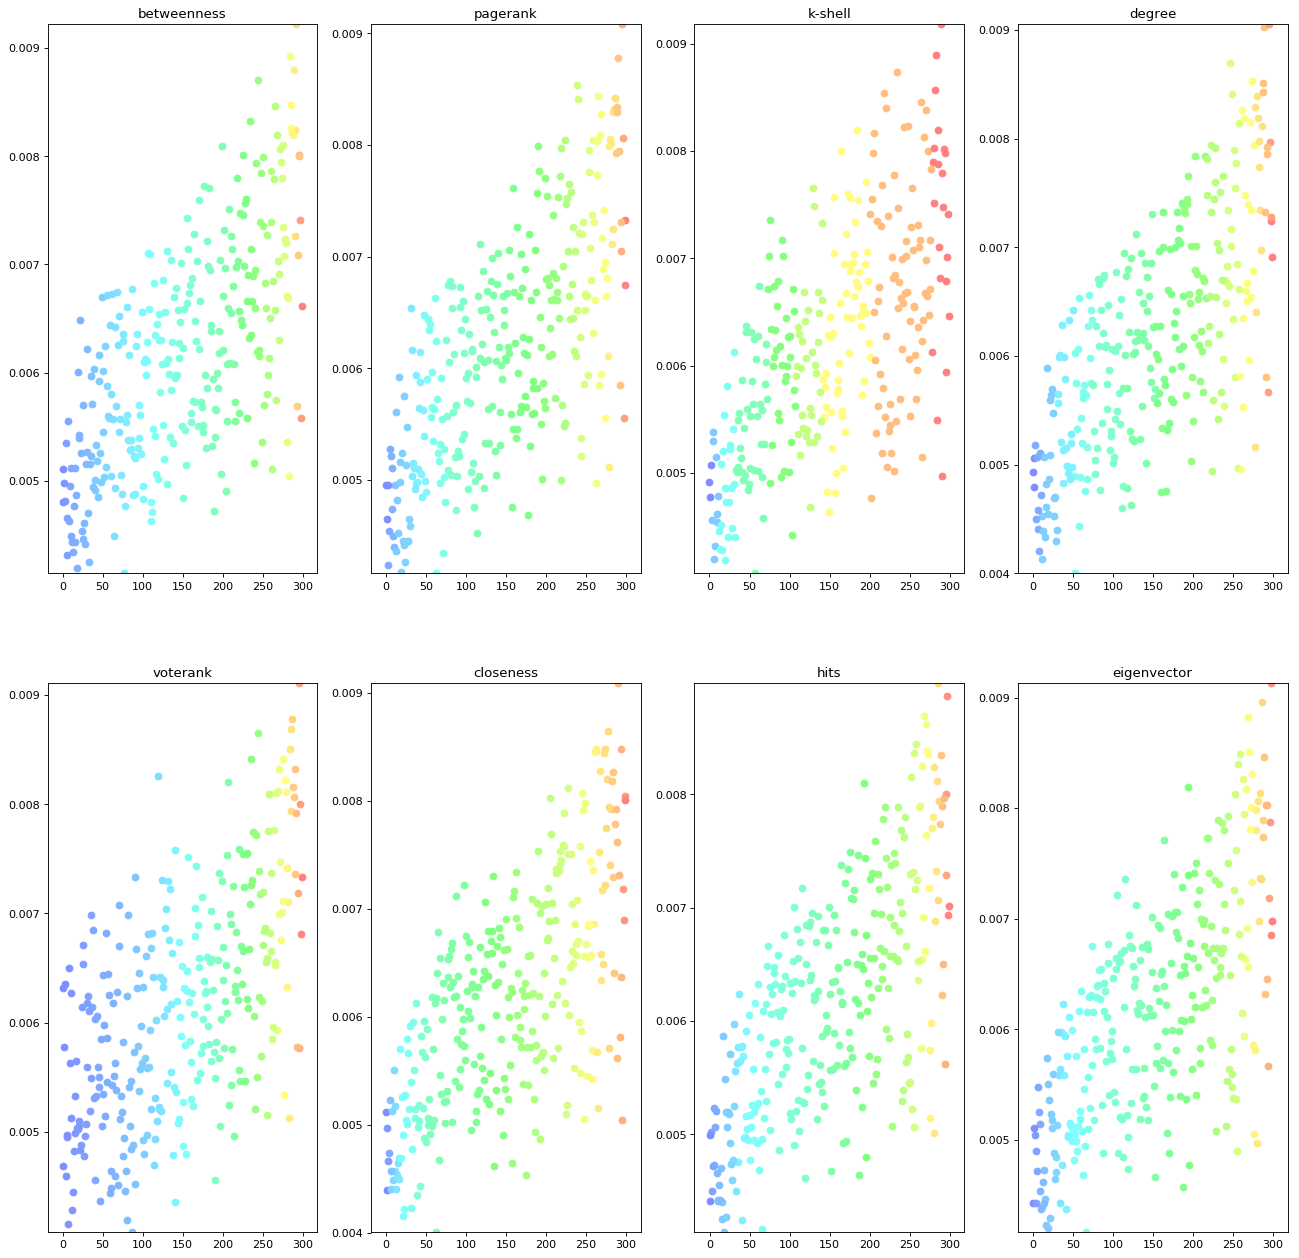

In [14]:
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for method_idx in range(1, spread_val.shape[0]):
    method_scores_spread = spread_val[method_idx]
    method_scores_cent = cent_scores[method_idx]
    method_scores_cent = method_scores_cent - np.min(method_scores_cent)
    method_scores_cent = 0.65 * (method_scores_cent / np.max(method_scores_cent))
    # Find data ranks
    temp_sort = np.argsort(method_scores_cent)
    data_centrality_rank = np.empty(len(method_scores_cent), int)
    data_centrality_rank[temp_sort] = np.arange(len(method_scores_cent))
    sp = plt.subplot(240 + method_idx)
    for node_id in range(network_size):
        color_rgb = colorsys.hsv_to_rgb(0.65 - method_scores_cent[node_id], 0.5, 1.0)
        sp.scatter(data_centrality_rank[node_id], method_scores_spread[node_id],
                   c=(color_rgb[0], color_rgb[1], color_rgb[2], 1))
    sp.set_title(results_names[method_idx - 1])
    sp.set_ylim([np.min(method_scores_spread), np.max(method_scores_spread)])
plt.show(True)

### 1.1.2 BA-BA Network
In next step I will examin BA - BA Network

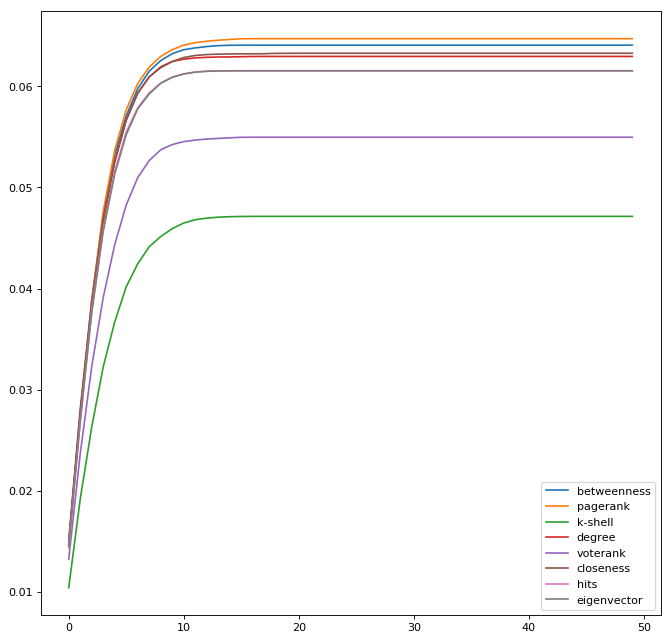

In [15]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for idx, method in enumerate(NX_CENTRALITY.keys()):
    if method == "supernode":
        continue
    avg_results = np.zeros((500, 50))
    for n_time in range(0, 500):
        cn = CentralityMeasure(agg_net_baba_nc)
        results_cn = cn.network_cn(method)
        if method == 'hits':
            results_cn = results_cn[1]
        best_nodes = sorted(results_cn.items(), key=lambda x: x[1])[::-1]
        beta_param = {0: {0: 0.1, 1: 0.1}, 1: {0: 0.1, 1: 0.1}}
        rec_param = {0: {0: 1.0, 1: 1.0}, 1: {0: 1.0, 1: 1.0}}
        sir = SIRMultiplex(multi_baba_nc, beta=beta_param, mu=rec_param, seed_nodes=[best_nodes[0][0]])
        result_sir = sir.run(epochs=50)
        avg_results[n_time] = np.array(result_sir)
    plt.plot(np.mean(avg_results, axis=0) / float(network_size * multi_baba_nc.network.shape[2]), 
             hold=True, label=method)
plt.legend()
plt.show(True)

In [16]:
cent_dict_baba = {}
cent_val_baba = {}
cent_dict_baba_15 = {}
cm_baba = CentralityMeasure(agg_net_baba_nc)
for method in NX_CENTRALITY.keys():
    if method == 'supernode':
        continue
    results = cm_baba.network_cn(method)
    if method == 'hits':
        results = results[1]
    best_nodes = sorted(results.items(), key=lambda x: x[1])[::-1]
    cent_val_baba[method] = sorted(results.values())[::-1]
    cent_dict_baba[method] = [cnt[0] for cnt in best_nodes]
    cent_dict_baba_15[method] = [cnt[0] for cnt in best_nodes[:15]]

In [17]:
scores = {}
scores_15 = {}
mean_realisation = 500
for method, nodes in cent_dict_baba.items():
    node_labels = []
    nodes_scores = []
    for node in nodes:
        mean_spread = []
        for _ in range(mean_realisation):
            beta_param = {0: {0: 0.1, 1: 0.1}, 1: {0: 0.1, 1: 0.1}}
            rec_param = {0: {0: 1.0, 1: 1.0}, 1: {0: 1.0, 1: 1.0}}
            sis = SIRMultiplex(multi_baba_nc, beta=beta_param, mu=rec_param, seed_nodes=[node])
            sis.run(epochs=10, visualize=False)
            mean_spread.append(sis.get_num('i') + sis.get_num('r'))
        node_labels.append(node)
        nodes_scores.append(np.mean(mean_spread))
    scores[method] = node_labels, nodes_scores
    scores_15[method] = nodes_scores[:15]
pd.DataFrame.from_dict(scores_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,35.660,37.588,37.306,39.436,39.106,26.792,38.288,32.914
1,35.540,23.408,34.110,31.190,30.026,25.106,32.028,25.006
2,32.988,29.754,24.008,31.294,31.870,31.570,34.602,32.526
3,24.718,32.816,32.348,24.892,24.144,33.004,24.562,29.102
4,30.226,32.466,30.462,33.802,33.034,38.992,31.692,28.480
5,23.344,29.454,27.950,28.642,28.662,18.564,28.146,25.600
6,29.182,27.566,22.580,27.480,26.232,24.620,21.502,24.058
7,24.234,24.970,26.270,22.918,22.228,20.510,26.402,24.266
8,26.708,23.680,25.224,25.318,24.022,16.174,23.798,23.806
9,26.822,23.004,26.024,27.936,25.188,24.686,29.232,28.176


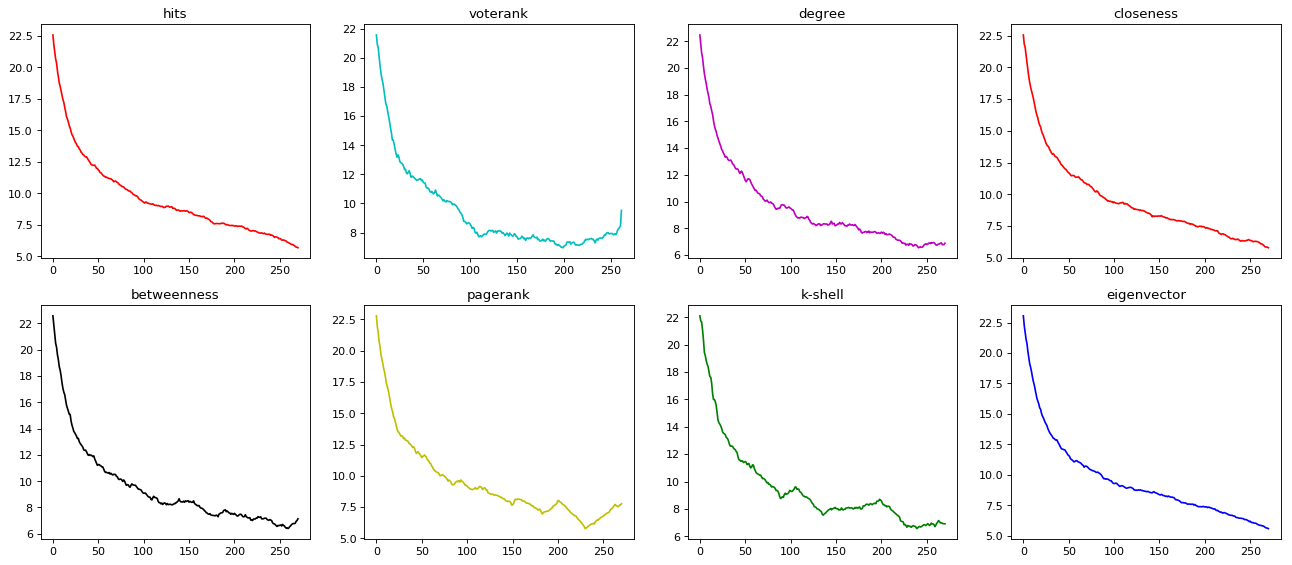

In [18]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
colors = "bgrcmrkygbb"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    sp = plt.subplot(840 + idx_counter)
    sp.plot(running_mean(nd_lab_scores[1], 30), colors[idx_counter + 1])
    sp.set_title(method)
    idx_counter += 1
plt.show()

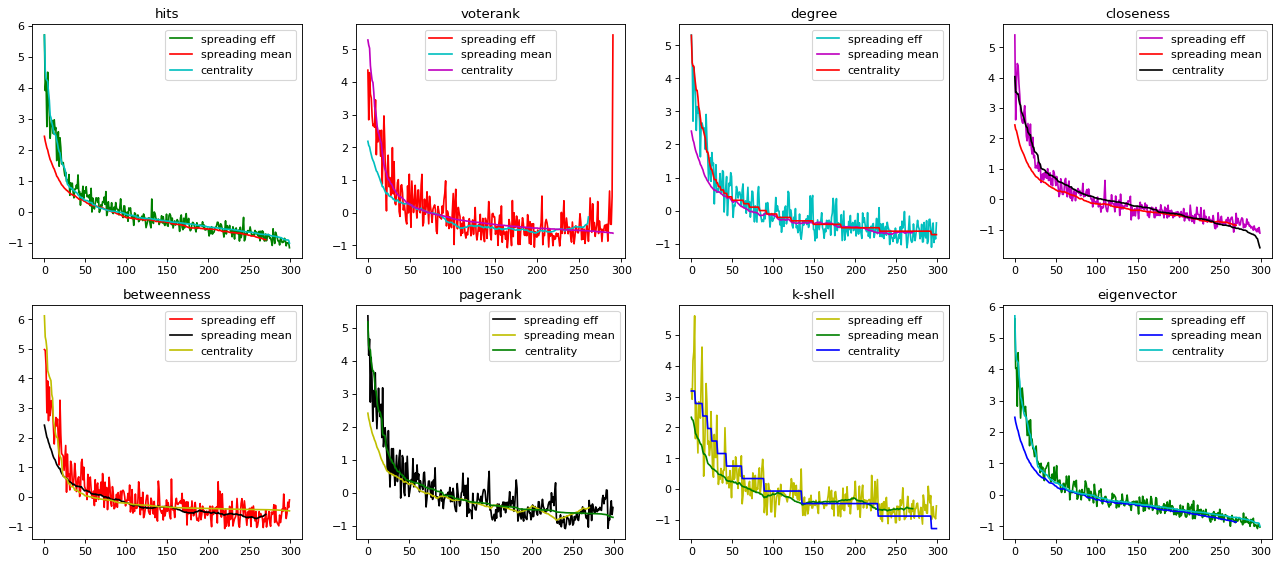

Kendal Correlation


,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,0.595875,0.823028,0.672281,0.827748,0.827606,0.677382,0.580685,0.460682


In [19]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
corr_kendal = {}
colors = "bgrcmrkygbcmgrc"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    normalized_spread = (np.array(nd_lab_scores[1]) - np.mean(nd_lab_scores[1])) / np.std(nd_lab_scores[1])
    normalized_cent = (cent_val_baba[method] - np.mean(cent_val_baba[method])) / np.std(cent_val_baba[method])
    sp = plt.subplot(840 + idx_counter)
    sp.plot(normalized_spread, colors[idx_counter], label="spreading eff")
    sp.plot(running_mean(normalized_spread, 30), colors[idx_counter + 1], label="spreading mean")
    sp.plot(normalized_cent, colors[idx_counter + 2], label="centrality")
    sp.legend()
    tau, p_value = stats.kendalltau(
                    nd_lab_scores[1],
                    cent_val_baba[method]
                )
    corr_kendal[method] = [tau]
    sp.set_title(method)
    idx_counter += 1
plt.show()
print("Kendal Correlation")
pd.DataFrame.from_dict(corr_kendal)

In [20]:
%%capture
print("Network generated and constructed!")
beta_param = {0: {0: 0.1, 1: 0.1}, 1: {0: 0.1, 1: 0.1}}
rec_param = {0: {0: 1.0, 1: 1.0}, 1: {0: 1.0, 1: 1.0}}
test_props = {'mean_num': 1500, "epochs": 35, "beta": beta_param, "mu": rec_param}
print("Start process...")
spread_val, cent_scores, results_names = spread_eff_centr_test(multi_baba_nc, test_properties=test_props)

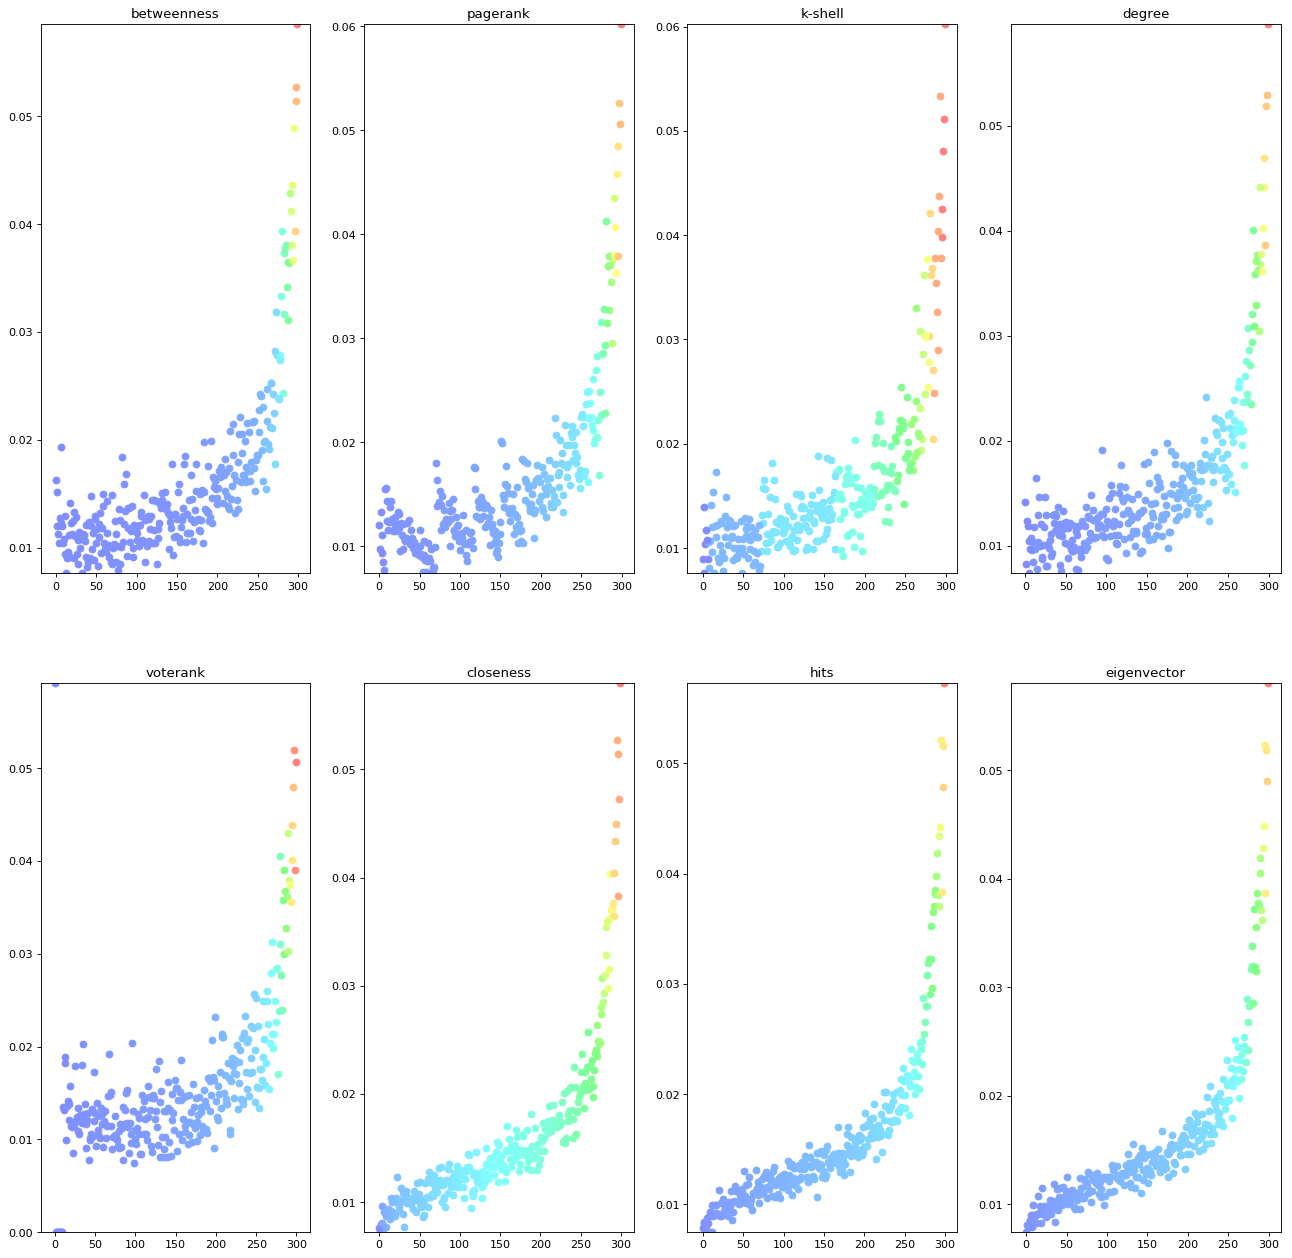

In [21]:
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for method_idx in range(1, spread_val.shape[0]):
    method_scores_spread = spread_val[method_idx]
    method_scores_cent = cent_scores[method_idx]
    method_scores_cent = method_scores_cent - np.min(method_scores_cent)
    method_scores_cent = 0.65 * (method_scores_cent / np.max(method_scores_cent))
    # Find data ranks
    temp_sort = np.argsort(method_scores_cent)
    data_centrality_rank = np.empty(len(method_scores_cent), int)
    data_centrality_rank[temp_sort] = np.arange(len(method_scores_cent))
    sp = plt.subplot(240 + method_idx)
    for node_id in range(network_size):
        color_rgb = colorsys.hsv_to_rgb(0.65 - method_scores_cent[node_id], 0.5, 1.0)
        sp.scatter(data_centrality_rank[node_id], method_scores_spread[node_id],
                   c=(color_rgb[0], color_rgb[1], color_rgb[2], 1))
    sp.set_title(results_names[method_idx - 1])
    sp.set_ylim([np.min(method_scores_spread), np.max(method_scores_spread)])
plt.show(True)

### 1.1.3 ER-BA Network

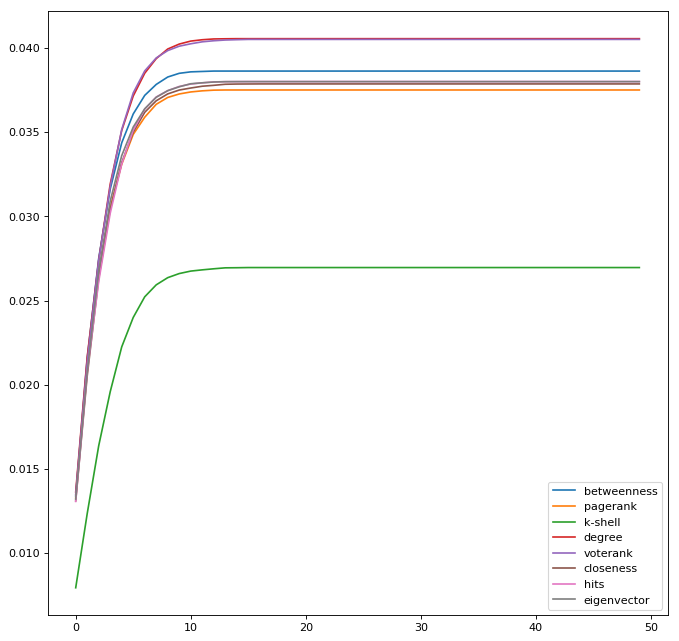

In [22]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for idx, method in enumerate(NX_CENTRALITY.keys()):
    if method == "supernode":
        continue
    avg_results = np.zeros((500, 50))
    for n_time in range(0, 500):
        cn = CentralityMeasure(agg_net_erba)
        results_cn = cn.network_cn(method)
        if method == 'hits':
            results_cn = results_cn[1]
        best_nodes = sorted(results_cn.items(), key=lambda x: x[1])[::-1]
        beta_param = {0: {0: 0.1, 1: 0.1}, 1: {0: 0.1, 1: 0.1}}
        rec_param = {0: {0: 1.0, 1: 1.0}, 1: {0: 1.0, 1: 1.0}}
        sir = SIRMultiplex(multi_erba, beta=beta_param, mu=rec_param, seed_nodes=[best_nodes[0][0]])
        result_sir = sir.run(epochs=50)
        avg_results[n_time] = np.array(result_sir)
    plt.plot(np.mean(avg_results, axis=0) / float(network_size * multi_erba.network.shape[2]), 
             hold=True, label=method)
plt.legend()
plt.show(True)

In [23]:
cent_dict_erba = {}
cent_val_erba = {}
cent_dict_erba_15 = {}
cm_erba = CentralityMeasure(agg_net_erba)
for method in NX_CENTRALITY.keys():
    if method == 'supernode':
        continue
    results = cm_erba.network_cn(method)
    if method == 'hits':
        results = results[1]
    best_nodes = sorted(results.items(), key=lambda x: x[1])[::-1]
    cent_val_erba[method] = sorted(results.values())[::-1]
    cent_dict_erba[method] = [cnt[0] for cnt in best_nodes]
    cent_dict_erba_15[method] = [cnt[0] for cnt in best_nodes[:15]]

In [24]:
scores = {}
scores_15 = {}
mean_realisation = 500
for method, nodes in cent_dict_erba.items():
    node_labels = []
    nodes_scores = []
    for node in nodes:
        mean_spread = []
        for _ in range(mean_realisation):
            beta_param = {0: {0: 0.1, 1: 0.1}, 1: {0: 0.1, 1: 0.1}}
            rec_param = {0: {0: 1.0, 1: 1.0}, 1: {0: 1.0, 1: 1.0}}
            sis = SIRMultiplex(multi_erba, beta=beta_param, mu=rec_param, seed_nodes=[node])
            sis.run(epochs=10, visualize=False)
            mean_spread.append(sis.get_num('i') + sis.get_num('r'))
        node_labels.append(node)
        nodes_scores.append(np.mean(mean_spread))
    scores[method] = node_labels, nodes_scores
    scores_15[method] = nodes_scores[:15]
pd.DataFrame.from_dict(scores_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,23.680,23.404,23.620,23.676,22.478,16.258,23.352,24.146
1,20.530,21.904,19.664,19.638,21.006,18.588,17.986,19.854
2,18.392,19.442,20.300,19.114,18.792,24.528,19.864,20.624
3,18.290,18.738,17.780,18.048,18.252,14.758,18.800,18.514
4,15.548,18.816,16.988,17.302,18.494,13.858,15.672,17.100
5,17.792,16.082,15.318,16.410,16.296,18.124,15.314,14.200
6,15.010,17.002,19.274,15.754,16.030,16.166,18.774,18.626
7,13.986,14.910,16.400,15.564,13.784,5.424,15.218,15.084
8,15.432,15.328,15.392,15.628,16.200,5.104,16.180,16.058
9,16.920,15.332,19.174,15.540,12.792,7.122,17.324,12.922


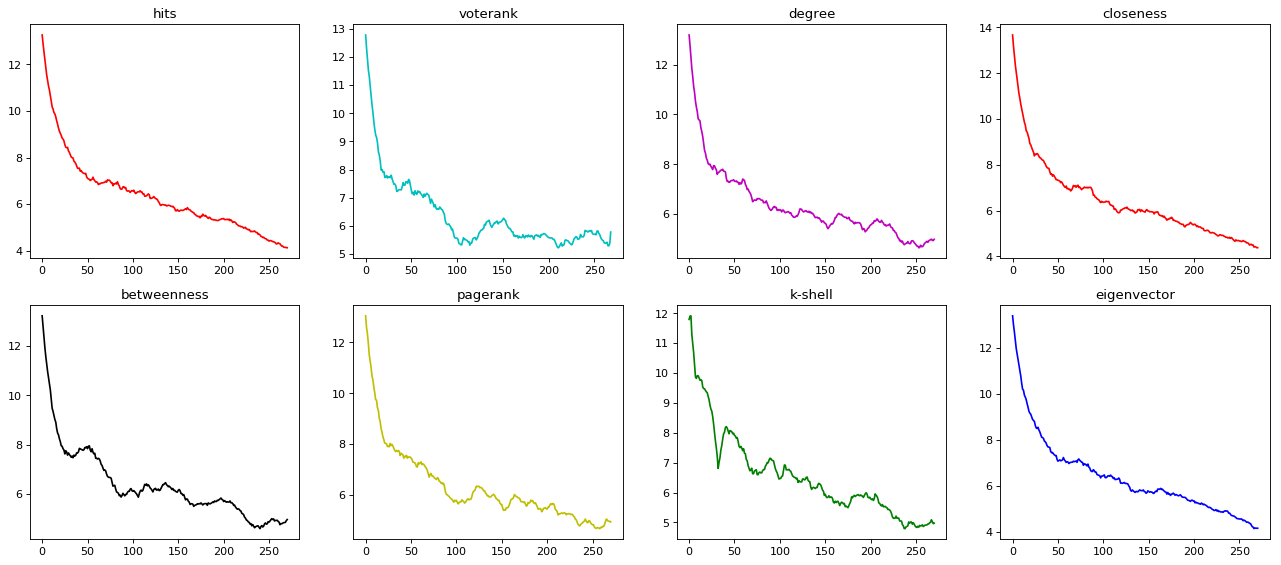

In [25]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
colors = "bgrcmrkygbb"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    sp = plt.subplot(840 + idx_counter)
    sp.plot(running_mean(nd_lab_scores[1], 30), colors[idx_counter + 1])
    sp.set_title(method)
    idx_counter += 1
plt.show()

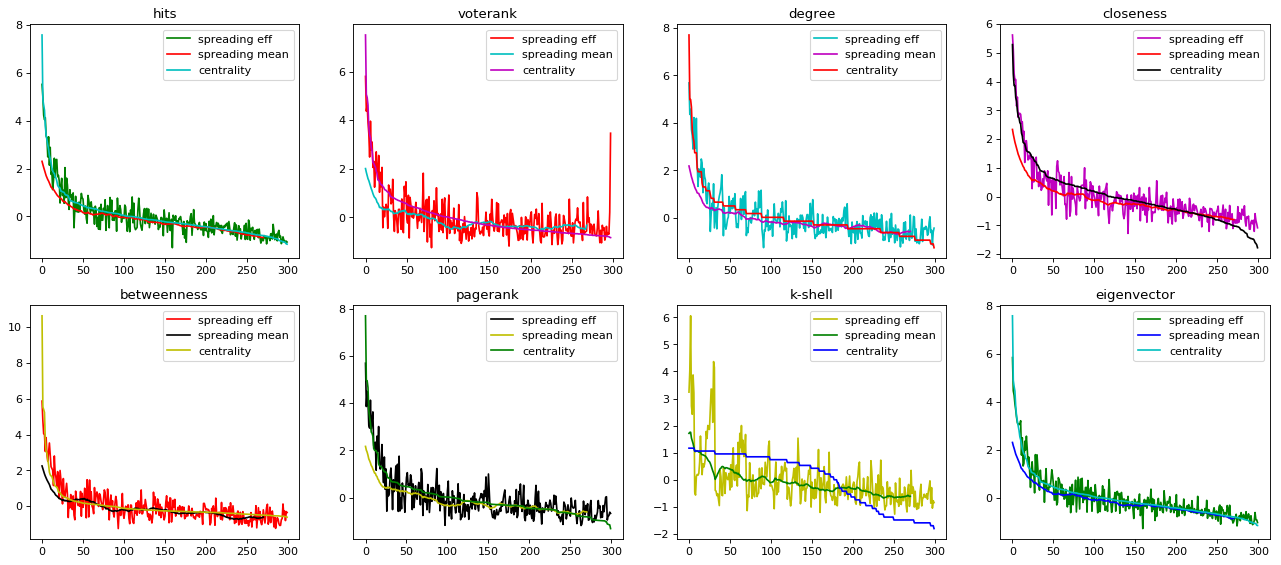

Kendal Correlation


,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,0.493037,0.643879,0.516777,0.669343,0.671811,0.449255,0.475653,0.349766


In [26]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
corr_kendal = {}
colors = "bgrcmrkygbcmgrc"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    normalized_spread = (np.array(nd_lab_scores[1]) - np.mean(nd_lab_scores[1])) / np.std(nd_lab_scores[1])
    normalized_cent = (cent_val_erba[method] - np.mean(cent_val_erba[method])) / np.std(cent_val_erba[method])
    sp = plt.subplot(840 + idx_counter)
    sp.plot(normalized_spread, colors[idx_counter], label="spreading eff")
    sp.plot(running_mean(normalized_spread, 30), colors[idx_counter + 1], label="spreading mean")
    sp.plot(normalized_cent, colors[idx_counter + 2], label="centrality")
    sp.legend()
    tau, p_value = stats.kendalltau(
                    nd_lab_scores[1],
                    cent_val_erba[method]
                )
    corr_kendal[method] = [tau]
    sp.set_title(method)
    idx_counter += 1
plt.show()
print("Kendal Correlation")
pd.DataFrame.from_dict(corr_kendal)

In [27]:
%%capture
print("Network generated and constructed!")
beta_param = {0: {0: 0.1, 1: 0.1}, 1: {0: 0.1, 1: 0.1}}
rec_param = {0: {0: 1.0, 1: 1.0}, 1: {0: 1.0, 1: 1.0}}
test_props = {'mean_num': 1500, "epochs": 35, "beta": beta_param, "mu": rec_param}
print("Start process...")
spread_val, cent_scores, results_names = spread_eff_centr_test(multi_baba_nc, test_properties=test_props)

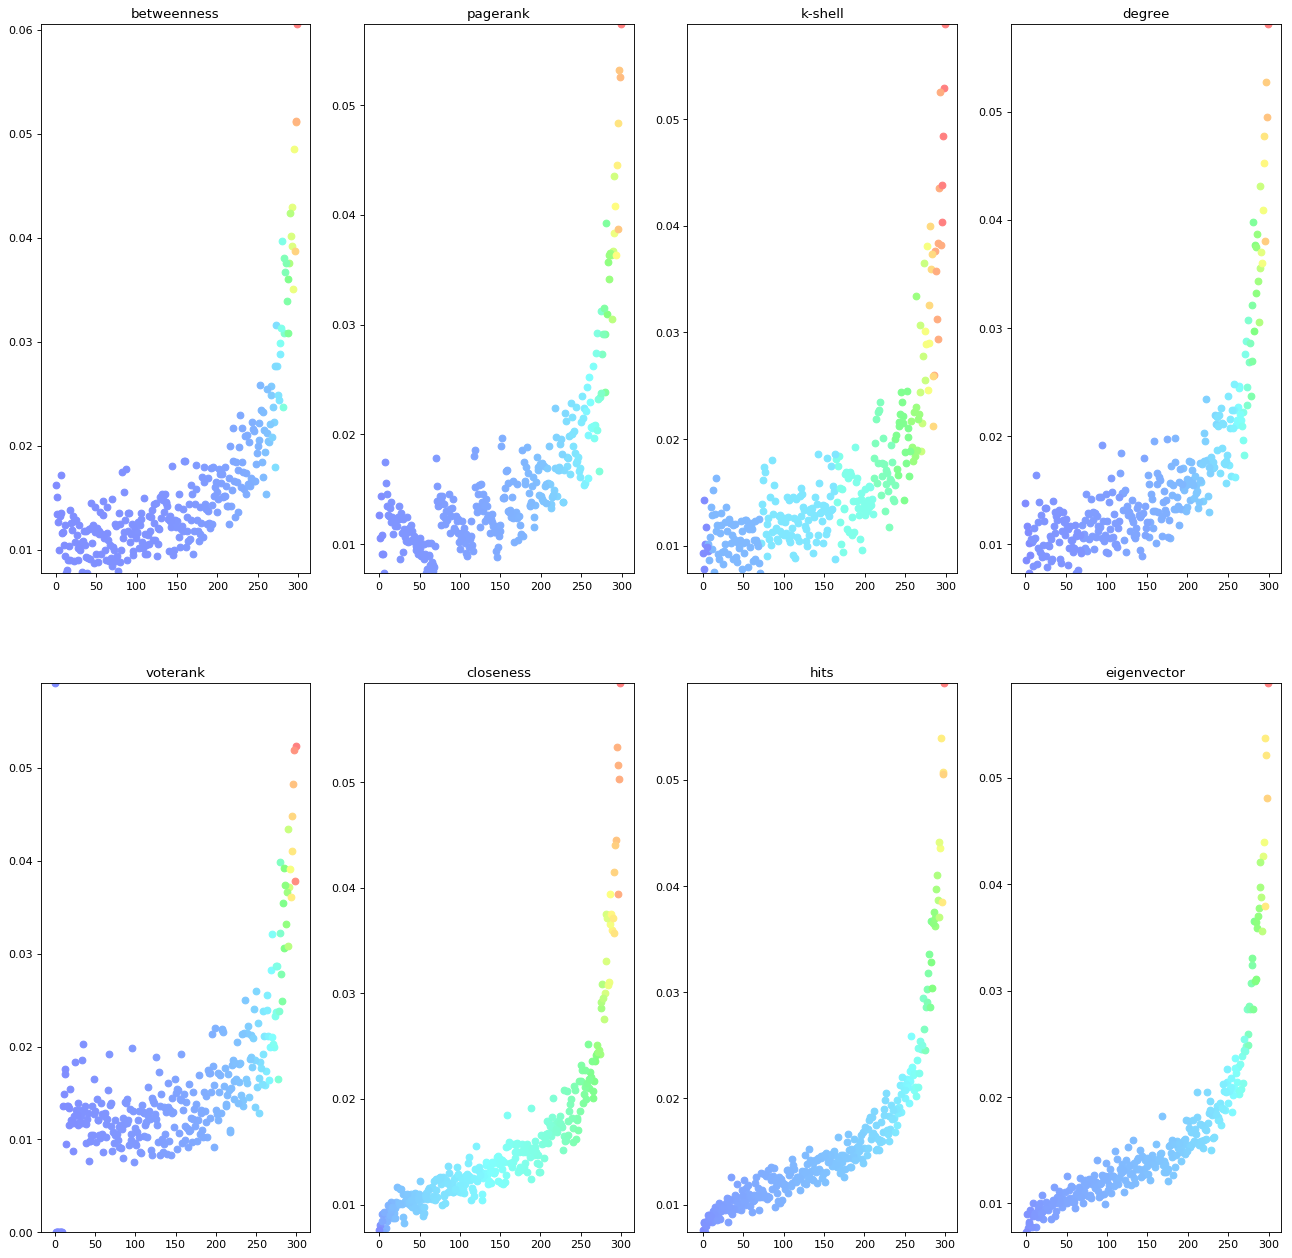

In [28]:
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for method_idx in range(1, spread_val.shape[0]):
    method_scores_spread = spread_val[method_idx]
    method_scores_cent = cent_scores[method_idx]
    method_scores_cent = method_scores_cent - np.min(method_scores_cent)
    method_scores_cent = 0.65 * (method_scores_cent / np.max(method_scores_cent))
    # Find data ranks
    temp_sort = np.argsort(method_scores_cent)
    data_centrality_rank = np.empty(len(method_scores_cent), int)
    data_centrality_rank[temp_sort] = np.arange(len(method_scores_cent))
    sp = plt.subplot(240 + method_idx)
    for node_id in range(network_size):
        color_rgb = colorsys.hsv_to_rgb(0.65 - method_scores_cent[node_id], 0.5, 1.0)
        sp.scatter(data_centrality_rank[node_id], method_scores_spread[node_id],
                   c=(color_rgb[0], color_rgb[1], color_rgb[2], 1))
    sp.set_title(results_names[method_idx - 1])
    sp.set_ylim([np.min(method_scores_spread), np.max(method_scores_spread)])
plt.show(True)

### 1.1.4 BA - BA Network Correlated

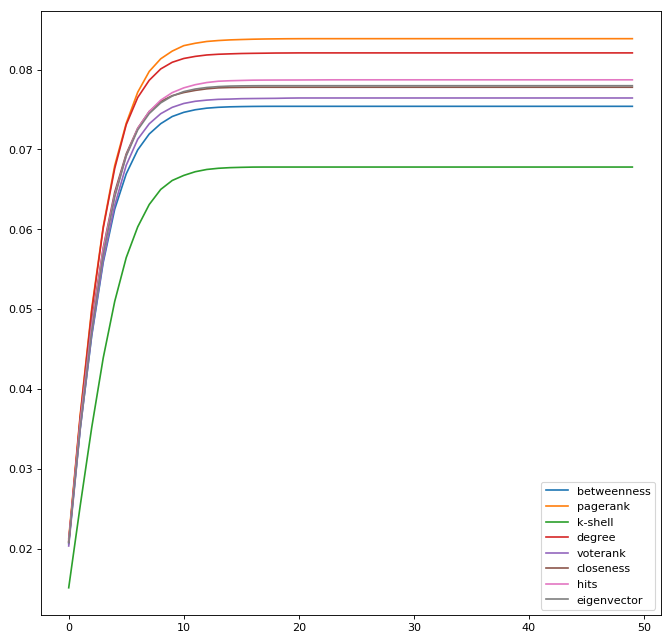

In [36]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for idx, method in enumerate(NX_CENTRALITY.keys()):
    if method == "supernode":
        continue
    avg_results = np.zeros((500, 50))
    for n_time in range(0, 500):
        cn = CentralityMeasure(agg_net_baba_corr)
        results_cn = cn.network_cn(method)
        if method == 'hits':
            results_cn = results_cn[1]
        best_nodes = sorted(results_cn.items(), key=lambda x: x[1])[::-1]
        beta_param = {0: {0: 0.1, 1: 0.1}, 1: {0: 0.1, 1: 0.1}}
        rec_param = {0: {0: 1.0, 1: 1.0}, 1: {0: 1.0, 1: 1.0}}
        sir = SIRMultiplex(multi_baba_corr, beta=beta_param, mu=rec_param, seed_nodes=[best_nodes[0][0]])
        result_sir = sir.run(epochs=50)
        avg_results[n_time] = np.array(result_sir)
    plt.plot(np.mean(avg_results, axis=0) / float(network_size * multi_baba_corr.network.shape[2]), 
             hold=True, label=method)
plt.legend()
plt.show(True)

In [37]:
cent_dict_baba_corr = {}
cent_val_baba_corr = {}
cent_dict_baba_corr_15 = {}
cm_baba_corr = CentralityMeasure(agg_net_baba_corr)
for method in NX_CENTRALITY.keys():
    if method == 'supernode':
        continue
    results = cm_baba_corr.network_cn(method)
    if method == 'hits':
        results = results[1]
    best_nodes = sorted(results.items(), key=lambda x: x[1])[::-1]
    cent_val_baba_corr[method] = sorted(results.values())[::-1]
    cent_dict_baba_corr[method] = [cnt[0] for cnt in best_nodes]
    cent_dict_baba_corr_15[method] = [cnt[0] for cnt in best_nodes[:15]]

In [38]:
scores = {}
scores_15 = {}
mean_realisation = 500
for method, nodes in cent_dict_baba_corr.items():
    node_labels = []
    nodes_scores = []
    for node in nodes:
        mean_spread = []
        for _ in range(mean_realisation):
            beta_param = {0: {0: 0.1, 1: 0.1}, 1: {0: 0.1, 1: 0.1}}
            rec_param = {0: {0: 1.0, 1: 1.0}, 1: {0: 1.0, 1: 1.0}}
            sis = SIRMultiplex(multi_baba_corr, beta=beta_param, mu=rec_param, seed_nodes=[node])
            sis.run(epochs=10, visualize=False)
            mean_spread.append(sis.get_num('i') + sis.get_num('r'))
        node_labels.append(node)
        nodes_scores.append(np.mean(mean_spread))
    scores[method] = node_labels, nodes_scores
    scores_15[method] = nodes_scores[:15]
pd.DataFrame.from_dict(scores_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,46.468,47.502,46.782,48.032,48.396,37.236,45.422,47.554
1,35.064,37.808,35.992,38.502,39.296,46.604,35.580,37.634
2,37.254,38.626,39.212,37.620,35.282,23.212,38.834,37.752
3,38.004,36.864,35.966,36.964,37.472,26.072,36.412,36.810
4,35.476,35.160,35.220,36.280,35.552,32.138,33.866,34.098
5,31.694,32.036,32.646,31.112,31.642,26.966,30.316,31.742
6,30.200,27.932,29.898,28.174,29.462,39.312,28.542,27.914
7,29.226,30.166,29.056,30.688,29.210,32.334,29.072,28.292
8,28.242,28.654,29.366,31.424,29.950,31.686,30.976,29.952
9,30.684,28.862,30.460,28.650,27.316,30.186,31.340,24.112


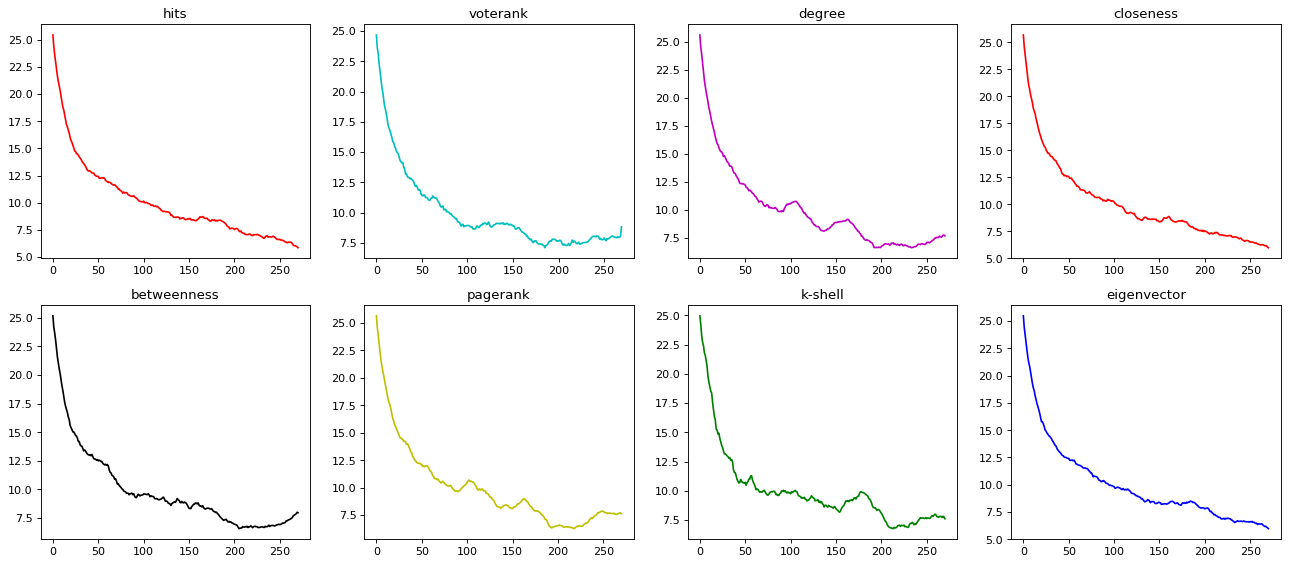

In [39]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
colors = "bgrcmrkygbb"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    sp = plt.subplot(840 + idx_counter)
    sp.plot(running_mean(nd_lab_scores[1], 30), colors[idx_counter + 1])
    sp.set_title(method)
    idx_counter += 1
plt.show()

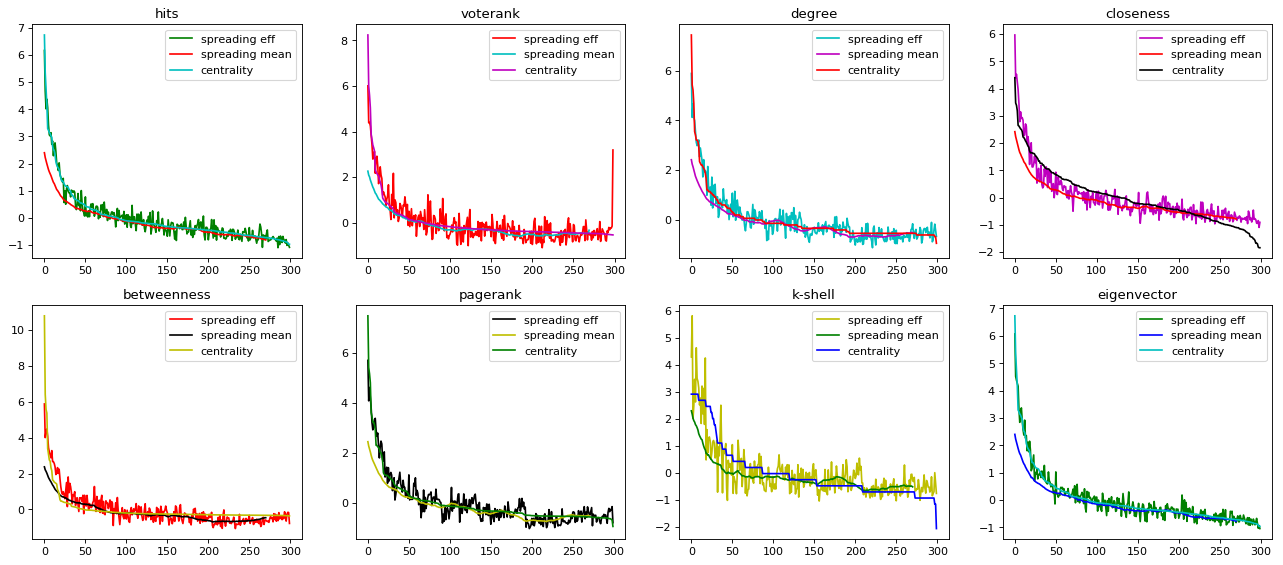

Kendal Correlation


,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,0.569005,0.738555,0.662503,0.746895,0.751759,0.508501,0.588652,0.466258


In [40]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
corr_kendal = {}
colors = "bgrcmrkygbcmgrc"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    normalized_spread = (np.array(nd_lab_scores[1]) - np.mean(nd_lab_scores[1])) / np.std(nd_lab_scores[1])
    normalized_cent = (cent_val_baba_corr[method] - np.mean(cent_val_baba_corr[method])) / np.std(cent_val_baba_corr[method])
    sp = plt.subplot(840 + idx_counter)
    sp.plot(normalized_spread, colors[idx_counter], label="spreading eff")
    sp.plot(running_mean(normalized_spread, 30), colors[idx_counter + 1], label="spreading mean")
    sp.plot(normalized_cent, colors[idx_counter + 2], label="centrality")
    sp.legend()
    tau, p_value = stats.kendalltau(
                    nd_lab_scores[1],
                    cent_val_baba_corr[method]
                )
    corr_kendal[method] = [tau]
    sp.set_title(method)
    idx_counter += 1
plt.show()
print("Kendal Correlation")
pd.DataFrame.from_dict(corr_kendal)

In [41]:
%%capture
print("Network generated and constructed!")
beta_param = {0: {0: 0.1, 1: 0.1}, 1: {0: 0.1, 1: 0.1}}
rec_param = {0: {0: 1.0, 1: 1.0}, 1: {0: 1.0, 1: 1.0}}
test_props = {'mean_num': 1500, "epochs": 35, "beta": beta_param, "mu": rec_param}
print("Start process...")
spread_val, cent_scores, results_names = spread_eff_centr_test(multi_baba_corr, test_properties=test_props)

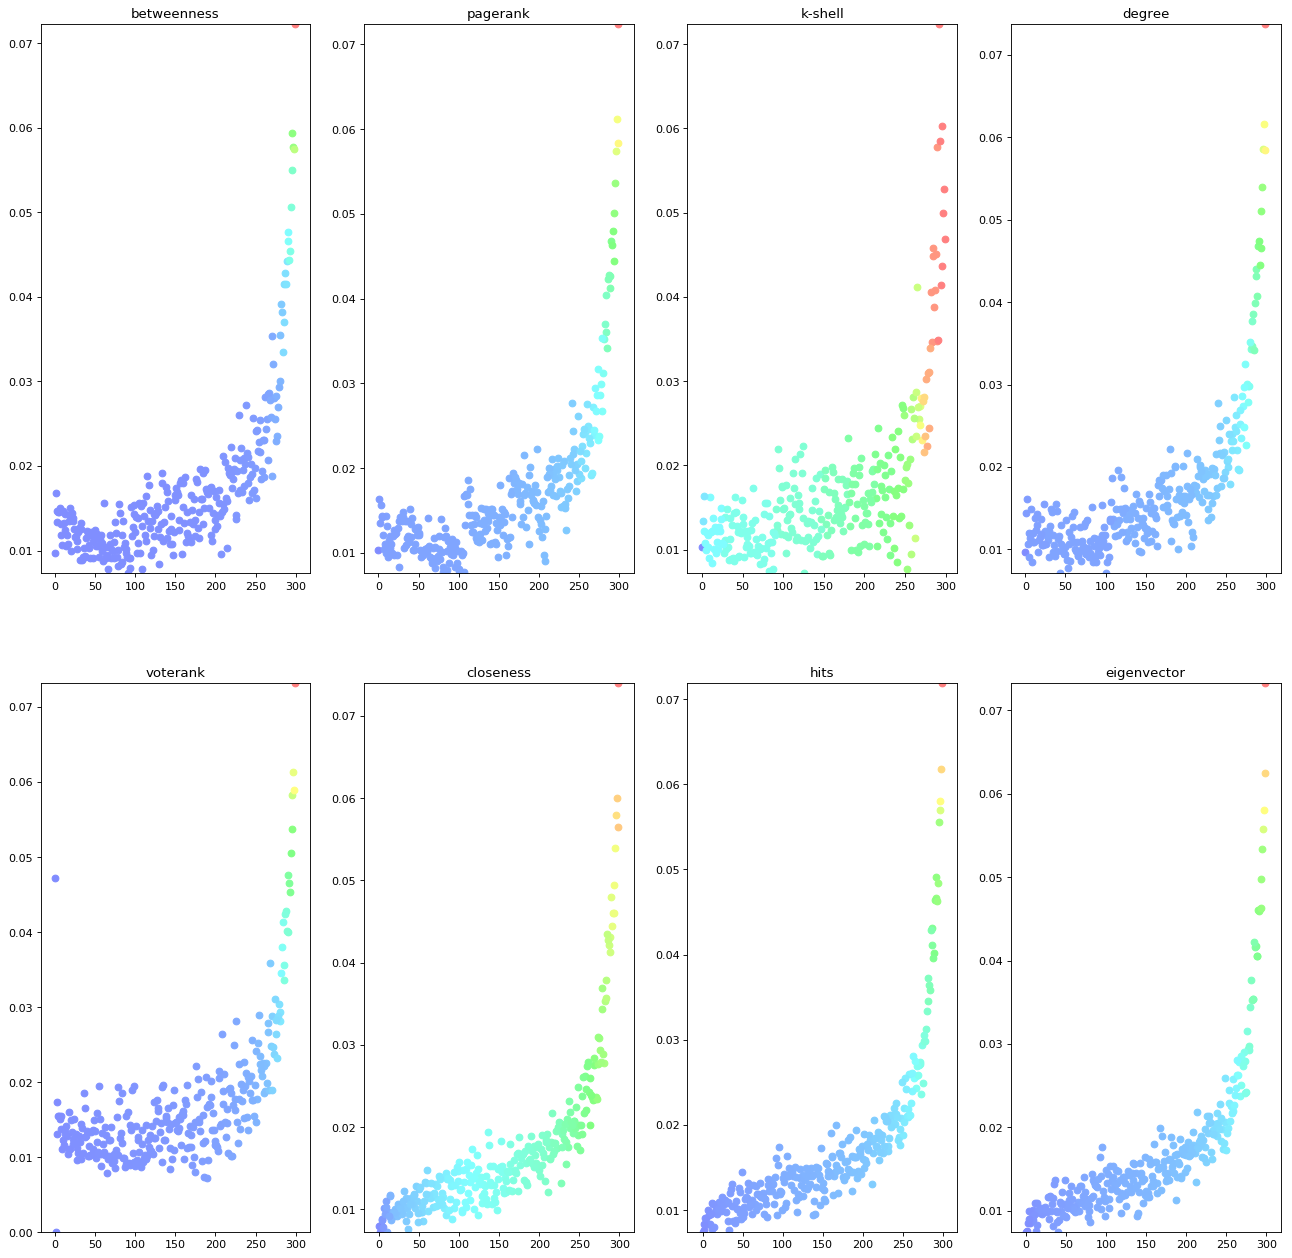

In [42]:
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for method_idx in range(1, spread_val.shape[0]):
    method_scores_spread = spread_val[method_idx]
    method_scores_cent = cent_scores[method_idx]
    method_scores_cent = method_scores_cent - np.min(method_scores_cent)
    method_scores_cent = 0.65 * (method_scores_cent / np.max(method_scores_cent))
    # Find data ranks
    temp_sort = np.argsort(method_scores_cent)
    data_centrality_rank = np.empty(len(method_scores_cent), int)
    data_centrality_rank[temp_sort] = np.arange(len(method_scores_cent))
    sp = plt.subplot(240 + method_idx)
    for node_id in range(network_size):
        color_rgb = colorsys.hsv_to_rgb(0.65 - method_scores_cent[node_id], 0.5, 1.0)
        sp.scatter(data_centrality_rank[node_id], method_scores_spread[node_id],
                   c=(color_rgb[0], color_rgb[1], color_rgb[2], 1))
    sp.set_title(results_names[method_idx - 1])
    sp.set_ylim([np.min(method_scores_spread), np.max(method_scores_spread)])
plt.show(True)